<br/>

$$ \huge{\underline{\textbf{ Model Free Control - Off Policy }}} $$

$$ \Large{\textbf{ Part 3: Importance Sampling Methods }} $$

# Contents

* Intro
  * [Sources](#Sources)
  * [Introduction](#Introduction)
  * [Imports](#Imports) - import stuff from [part 1](../Lecture05/ModelFreeControl_Part1.html)
  * [SARSA - Refresher](#SARSA---Refresher) - refresher from [part 1](../Lecture05/ModelFreeControl_Part1.html#SARSA)

* Importance Sampling Methods
  * [Importance Sampling SARSA](#Importance-Sampling-SARSA) - off-policy SARSA using importance sampling
  * [N-Step Importance Sampling SARSA](#N-Step-Importance-Sampling-SARSA)
  * [Off-Policy MC Control](#Off-Policy-MC-Control)

# Sources

* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 5 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf
  * Lecture 5 vid: https://www.youtube.com/watch?v=0g4j2k_Ggc4
* Sutton and Barto 2018: http://incompleteideas.net/book/the-book-2nd.html

# Introduction

Same as [previous part](../Lecture05_Ctrl/ModelFreeControl_Part2.html), this post roughly corresponds to part 2 of Lecture 5 of UCL RL course by David Silver.

We will explore off-policy algorithms based on importance sampling, specifically SARSA with Importance Sampling (1-step) and n-step extension. Off-Policy Monte-Carlo is just N-Step SARSA with Importance Sampling with number of steps set higher than longest possible episode (+inf).

Let's have a look at algorithm zoo

<img src="assets/alg_zoo.png"/>
<center>Table: Numbers in bracket refer to chapters in Sutton and Barto 2018</center>
<center>Implementations in this notebook do not exactly correspond to the book</center>

<br/>

And let's bring back mini-MDP. Mini-MDP is described properly in [previous part](../Lecture05_Ctrl/ModelFreeControl_Part2.html)

<img src="assets/mini-mdp.png"/>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Environment is exactly the same as in [part 1](ModelFreeControl_Part1.html)
<img src="assets/corridor2.png"/>

In [2]:
from ModelFreeControl_Part1 import LinearEnv, REF_RANDOM, REF_GREEDY

Let's create environment and policies for future use

In [3]:
env = LinearEnv()

pi_random = np.tile([0.50, 0.50], [11, 1])  # starting random policy
pi_greedy = np.tile([0.00, 1.00], [11, 1])  # optimal greedy policy
pi_skewed = np.tile([0.40, 0.60], [11, 1])  # will use this later

And import common functions, they are also exactly the same as in [part 1](ModelFreeControl_Part1.html)

In [4]:
from ModelFreeControl_Part1 import generate_episode, LogEntry, plot_experiments

# SARSA - Refresher

As in [previous part](../Lecture05_Ctrl/ModelFreeControl_Part2.html) we will build up from bare-bones SARSA into importance sampling methods.

SARSA update formula

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ \color{blue}{R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) }\color{black}{} - Q(S_t,A_t) \big] $$

So far we have established as follows:
* SARSA performs backups by sampling both reward and next state Q-value.
* Expected SARSA performs backups by sampling reward and then calculating expectation over all next-state Q-values. Expectation can be calculated by plugging in either behavioural or target policy.
  * Q-Learning is special case of Expected SARSA with greedy target policy

Importance Sampling SARSA does something even different, let's have a look

In [5]:
from ModelFreeControl_Part1 import make_eps_greedy, mc_control, sarsa

# Importance Sampling SARSA

Importance sampling is a well known concept in statistics. See [wikipedia](https://en.wikipedia.org/wiki/Importance_sampling) and [this](https://www.youtube.com/watch?v=S3LAOZxGcnk) and [this](https://www.youtube.com/watch?v=3Mw6ivkDVZc) videos.

Let's get back to wizard and oracle example. As in [previous part](../Lecture05_Ctrl/ModelFreeControl_Part2.html), oracle asks you to evaluate random policy, but you can only follow skewed policy 40%/60% left/right. This time you figure as follows:
* Same as before, $Q(R,l)$ and $Q(R,r)$ will evaluate correctly to +10 and +100 no matter what is behavioural and target policy (as long as you keep visiting them)
* as per $Q(S,f)$, there are two possibilities:
  * $40\%$ of a time you get to $Q(S,f)$, then left to small treasure - in this case you get reward $1+10=11$. But you know under target random policy you will get this reward $50\%$ of a time, not $40\%$, which means under _target policy_ you will get this reward $1.25$ as often ($\frac{.5}{.4} = 1.25$). So every time you take left door, you update towards target $\frac{.5}{.4} * 11 = 13.75$
  * $60\%$ of a time you get to $Q(S,f)$, then right to big treasure - in this case you get reward $1+100=101$. As earlier, you know that under target policy you will get this reward $50\%$ of a time, not $60\%$. Under target policy you will get this reward $0.8333333$ as often ($\frac{.5}{.6} = 0.8333333$). So you update towards target $ \frac{.5}{.6} * 101 = 84.1666666$
* if you go through mini-MDP enough times, and your step size is small enough, then your estimate for $Q(S,f)$ will eventually settle to

$$ Q(S,f) = 40\% * 13.75 + 60\% * 84.1666666 = 56 $$

Or in expanded form

$$ Q(S,f) = 40\% * \frac{.5}{.4} * 11 + 60\% * \frac{.5}{.6} * 101 = .5 * 11 + .5 * 101 = 56 $$

which is indeed correct for target policy! We managed to use importance sampling to correct for the fact that under _skewed policy_ we visit states with different frequency than under target policy.

Using above trick, we can write Importance Sampling update formala as follows

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[  \color{blue}{ \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}(R + \lambda Q(S_{t+1},A_{t+1})) } \color{black}{} - Q(S,f) \big] $$

Where:
* $\mu(a|s)$ is skewed behavioural policy

Let's write some code. Notice that only differene between imps_sarsa and exp_sarsa and q_learning from [previosu part](../Lecture05_Ctrl/ModelFreeControl_Part2.html) is changed _target_ line

In [6]:
def imps_sarsa(env, pol_beh, pol_tar, N, alpha, learn=True):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            # target = Rt_1 + 1.0 * Q[St_1, At_1]                                        # SARSA
            # target = Rt_1 + 1.0 * np.max(Q[St_1,:])                                    # Q-Learning
            # target = Rt_1 + 1.0 * np.sum(pol_tar[St_1,:] * Q[St_1,:])                  # Exp. SARSA
            target = (pol_tar[St_1, At_1] / pol_beh[St_1, At_1]) * (Rt_1 + 1.0 * Q[St_1, At_1])  # I.S. SARSA
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
            
        if learn:  # set eps to None to disable improvement step
            pol_tar = make_eps_greedy(Q, 0.0)  # eps 0.0 makes policy greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

### Off-Policy Prediction

Before we run proper experiments, let's just evaluate random policy while also following random policy. This is equivalent to TD Prediction from [part 1](../Lecture05_Ctrl/ModelFreeControl_Part1.html#TD-Prediction)

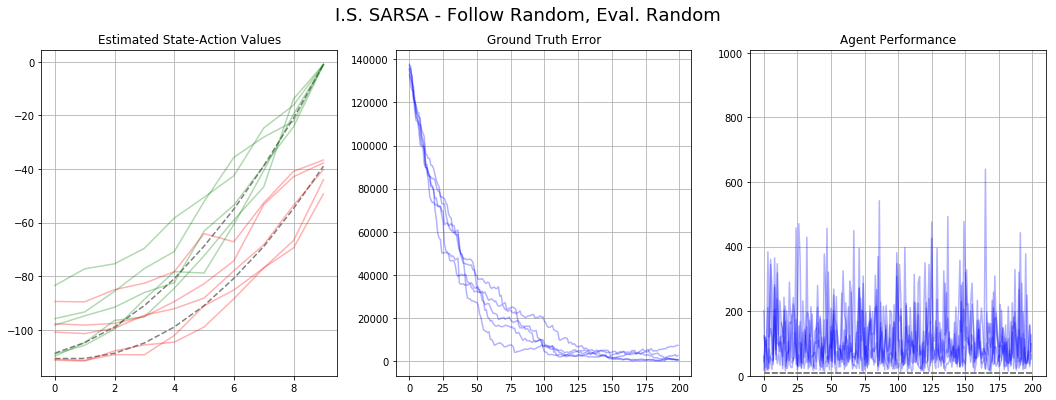

In [7]:
log = []
for _ in range(5):
    hist, perf = imps_sarsa(env, pol_beh=pi_random, pol_tar=pi_random, N=200, alpha=0.2, learn=False)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_RANDOM, 'I.S. SARSA - Follow Random, Eval. Random')

And same evaluation, but this time follow skewed and evaluate random. No learning.

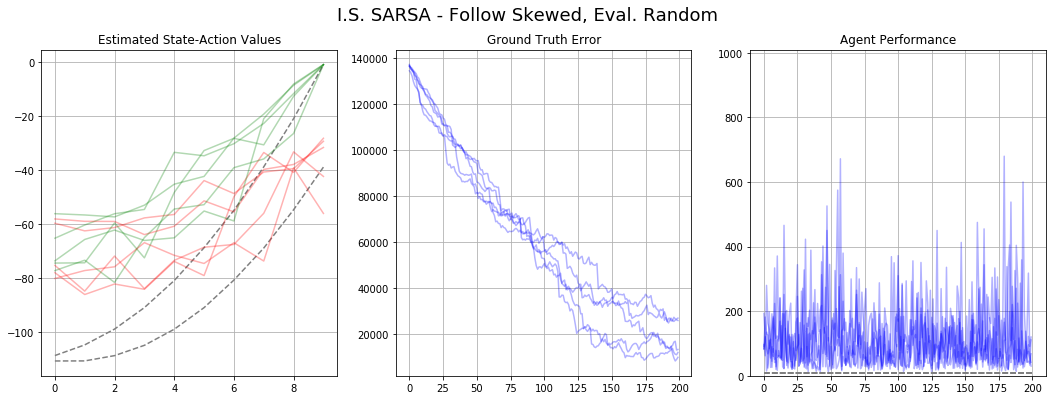

In [8]:
log = []
for _ in range(5):
    hist, perf = imps_sarsa(env, pol_beh=pi_skewed, pol_tar=pi_random, N=200, alpha=0.2, learn=False)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_RANDOM, 'I.S. SARSA - Follow Skewed, Eval. Random')

As we can see Q-Value plots is all over the place, and this is with importance sampling applied over _one_ time step. Imagine what will happen when we apply it over multiple time steps or whole episode length! Let's try again with smaller step size and larger number of steps

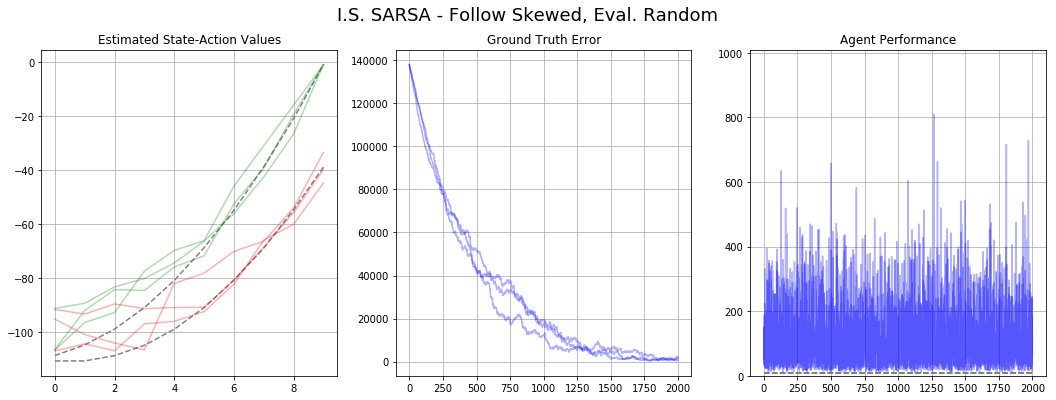

In [9]:
log = []
for _ in range(3):
    hist, perf = imps_sarsa(env, pol_beh=pi_skewed, pol_tar=pi_random, N=2000, alpha=0.05, learn=False)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_RANDOM, 'I.S. SARSA - Follow Skewed, Eval. Random')

This at least seems to converge.

### Off-Policy Control

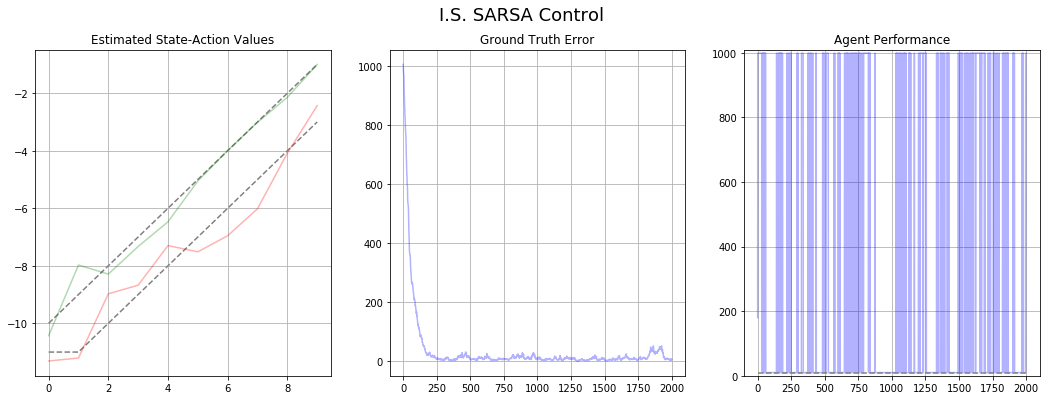

In [10]:
log = []
for _ in range(1):
    hist, perf = imps_sarsa(env, pol_beh=pi_random, pol_tar=pi_random, N=2000, alpha=0.01, learn=True)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'I.S. SARSA Control')

Control is a bit of a disaster. Part of the problem is that with greedy target policy expression $\pi({A_{t+1}}{S_{t+1}})$ will be equal to zero a lot, in which case learning will stop for these state-action pairs.

# N-Step Importance Sampling SARSA

In [11]:
def nstep_imps_sarsa(env, pol_beh, pol_tar, N, alpha, nstep=float('inf'), learn=True):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            
            disc = 1.0              # discount, tested with disc==1.0 only!
            T = len(trajectory)-1   # terminal state
            max_j = min(t+nstep, T) # last state iterated, inclusive
            tmp_disc = 1.0          # this will decay
            imps_mult = 1.0
            target = 0
            
            # Iterate from t+1 to t+nstep or T (inclusive start and finish)
            for j in range(t+1, max_j+1):
                Sj, Rj, _, Aj = trajectory[j]
                imps_mult *= (pol_tar[Sj, Aj] / pol_beh[Sj, Aj])
                target += tmp_disc * Rj
                tmp_disc *= disc
                
            # Note that Q[Sj, Aj] will have state-value of state t+nstep or
            # zero if t+nstep >= T as Q[St=T] must equal 0 for all actions
            Sj, _, _, Aj = trajectory[j]  # traj[j] is (obs, reward, done, action)
            target += tmp_disc * Q[Sj, Aj]
            target *= imps_mult
            
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
            
        if learn:  # set eps to None to disable improvement step
            pol_tar = make_eps_greedy(Q, 0.0)  # eps 0.0 makes policy greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

### Off-Policy Prediction

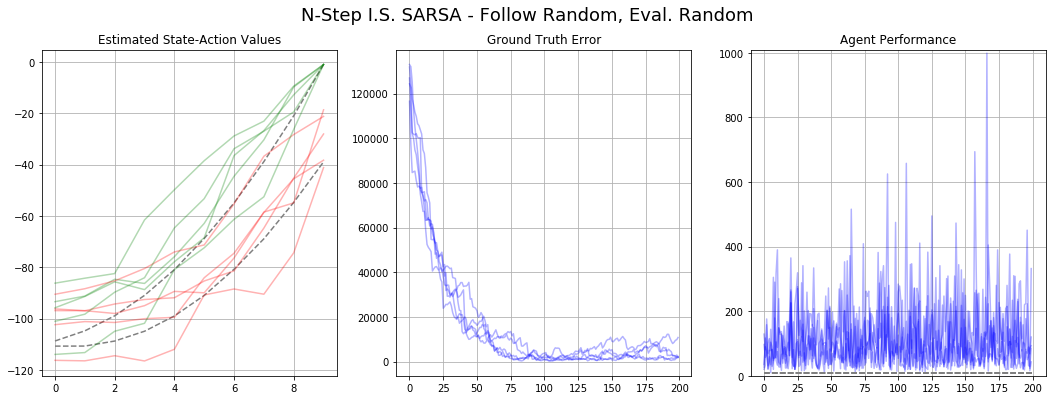

In [12]:
log = []
for _ in range(5):
    hist, perf = nstep_imps_sarsa(env, pol_beh=pi_random, pol_tar=pi_random, N=200, alpha=0.2, nstep=2, learn=False)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_RANDOM, 'N-Step I.S. SARSA - Follow Random, Eval. Random')

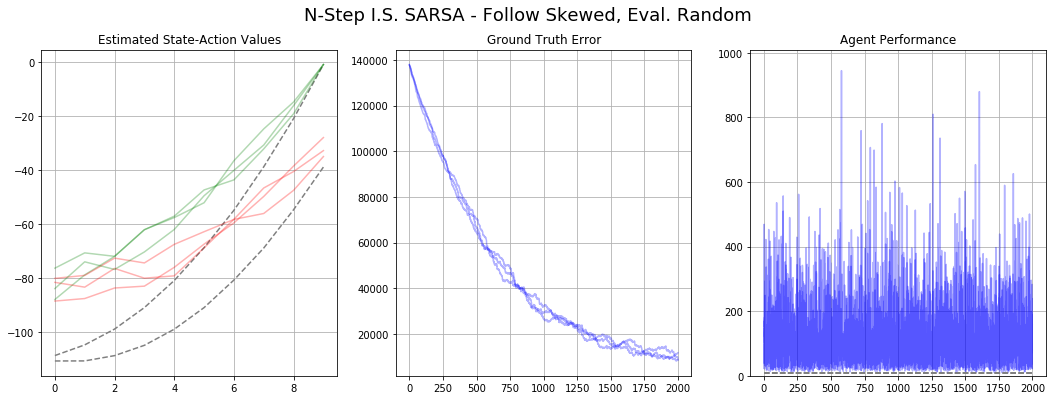

In [13]:
log = []
for _ in range(3):
    hist, perf = nstep_imps_sarsa(env, pol_beh=pi_skewed, pol_tar=pi_random, N=2000, alpha=0.01, nstep=3, learn=False)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_RANDOM, 'N-Step I.S. SARSA - Follow Skewed, Eval. Random')

It does converge, but sloooowly

### Off-Policy Control

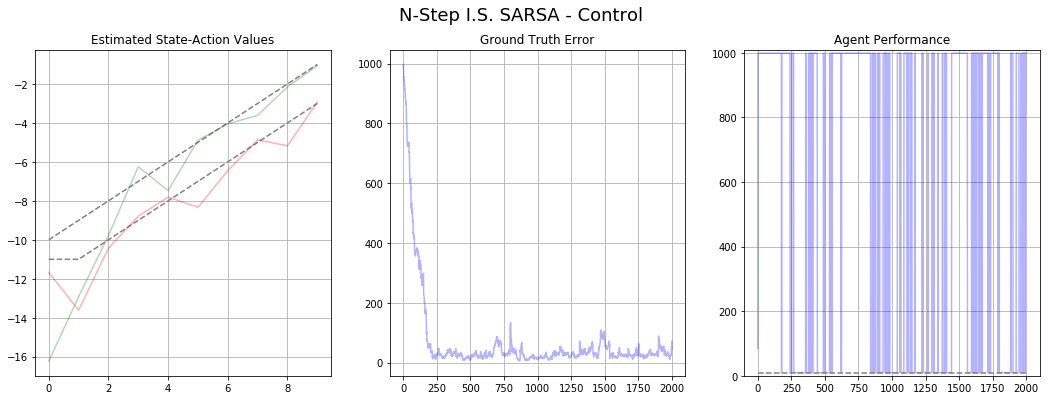

In [15]:
log = []
for _ in range(1):
    hist, perf = nstep_imps_sarsa(env, pol_beh=pi_skewed, pol_tar=pi_random, N=2000, alpha=0.01, nstep=3, learn=True)
    log.append(LogEntry('imps-sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'N-Step I.S. SARSA - Control')

In [16]:
np.argmax(hist[-1], axis=-1)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

It's not very good, but final policy seems to be roughly OK-ish some of the time. Apart of the variance, part of the problem is that due to high variance we need to use very low step-size, while at the same time our initial Q-Values are set to zero and algorithm needs to 'traverse' long distance from zero to actual Q-Value

# Off-Policy MC Control

Same as N-Step Importance Sampling SARSA, but with nstep hard coded to 'inf'. This is very naive implementation which is very, very slow and doesn't work in practice. You are probably better using version from Sutton Barto 2018 which is looping backward and uses weighted importance sampling. This algorithm is included only for completeness.

In [17]:
def offpolicy_mc(env, pol_beh, pol_tar, N, alpha, learn=True):
    nstep=float('inf')
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            
            disc = 1.0              # discount, tested with disc==1.0 only!
            T = len(trajectory)-1   # terminal state
            max_j = min(t+nstep, T) # last state iterated, inclusive
            tmp_disc = 1.0          # this will decay
            imps_mult = 1.0
            target = 0
            
            # Iterate from t+1 to t+nstep or T (inclusive start and finish)
            for j in range(t+1, max_j+1):
                Sj, Rj, _, Aj = trajectory[j]
                imps_mult *= (pol_tar[Sj, Aj] / pol_beh[Sj, Aj])
                target += tmp_disc * Rj
                tmp_disc *= disc
                
            # Note that Q[Sj, Aj] will have state-value of state t+nstep or
            # zero if t+nstep >= T as Q[St=T] must equal 0 for all actions
            Sj, _, _, Aj = trajectory[j]  # traj[j] is (obs, reward, done, action)
            target += tmp_disc * Q[Sj, Aj]
            target *= imps_mult
            
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
            
        if learn:  # set eps to None to disable improvement step
            pol_tar = make_eps_greedy(Q, 0.0)  # eps 0.0 makes policy greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

### Off-Policy Prediction

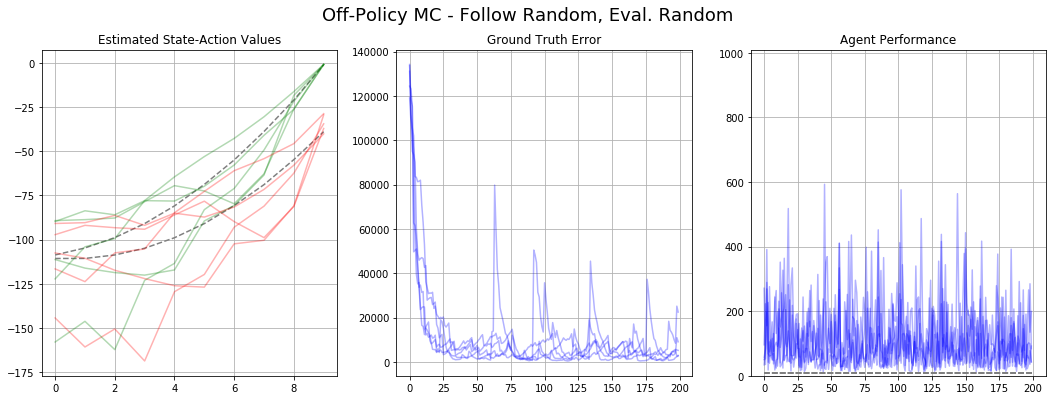

In [18]:
log = []
for _ in range(5):
    hist, perf = offpolicy_mc(env, pol_beh=pi_random, pol_tar=pi_random, N=200, alpha=0.01, learn=False)
    log.append(LogEntry('offpolicy_mc', hist, perf))
plot_experiments(log, REF_RANDOM, 'Off-Policy MC - Follow Random, Eval. Random')

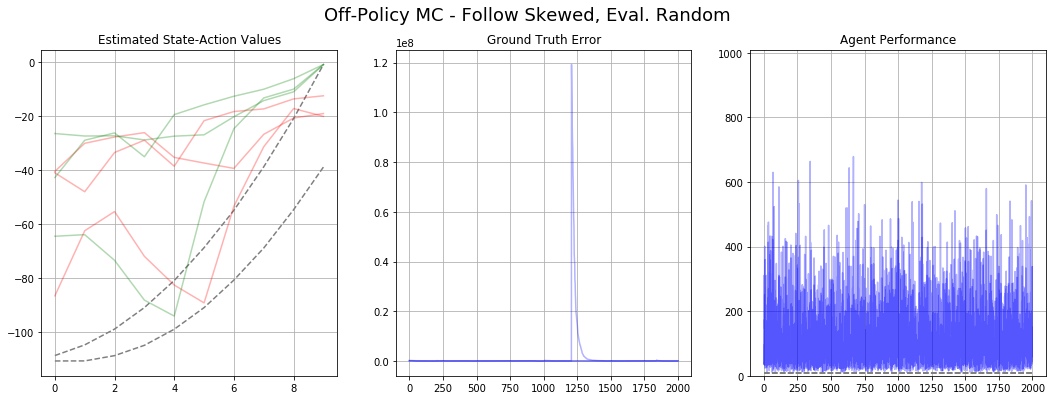

In [20]:
log = []
for _ in range(3):
    hist, perf = offpolicy_mc(env, pol_beh=pi_skewed, pol_tar=pi_random, N=2000, alpha=0.01, learn=False)
    log.append(LogEntry('offpolicy_mc', hist, perf))
plot_experiments(log, REF_RANDOM, 'Off-Policy MC - Follow Skewed, Eval. Random')

### Off-Policy Control

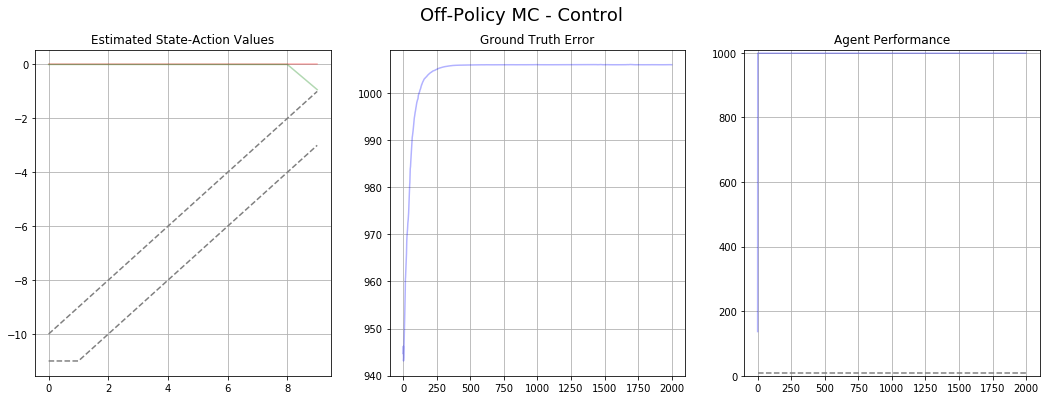

In [21]:
log = []
for _ in range(1):
    hist, perf = offpolicy_mc(env, pol_beh=pi_skewed, pol_tar=pi_random, N=2000, alpha=0.01, learn=True)
    log.append(LogEntry('offpolicy_mc', hist, perf))
plot_experiments(log, REF_GREEDY, 'Off-Policy MC - Control')